In [291]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.svm import SVC # for Support Vector Classification model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Task 1

In [292]:
# Load dataset 
dataset = pd.read_csv("./drive/MyDrive/UofM/ML/dataset2/customers_data.csv")

# Peek the dataset
print(dataset.head())

# Get information of the dataset and check for missing values and data types of each column
dataset.info()

     ID CHURNRISK GENDER STATUS  CHILDREN  ESTINCOME HOMEOWNER  AGE  \
0  1703    Medium      M      M         2    28766.9         N   47   
1  1704       Low      M      M         2    91272.2         Y   25   
2  1705       Low      F      S         0    73228.3         N   42   
3  1706      High      M      M         1    64792.3         N   52   
4  1707      High      F      S         0    93322.1         Y   40   

   TOTALDOLLARVALUETRADED  TOTALUNITSTRADED  LARGESTSINGLETRANSACTION  \
0                 6110.61                58                 1527.6525   
1                26992.70                13                13496.3500   
2                22472.25                28                11236.1250   
3                13051.31                36                 6525.6550   
4                29922.99                 8                14961.4950   

   SMALLESTSINGLETRANSACTION  PERCENTCHANGECALCULATION  DAYSSINCELASTLOGIN  \
0                  152.76525                      8.70  

In [293]:
# The size and the dimension of the original dataset
print("Size: ",dataset.size)
print("Dimension: ", dataset.shape)
print(f"There are {dataset.shape[0]} datapoints and {dataset.shape[1]} features in the original dataset.")

Size:  35122
Dimension:  (2066, 17)
There are 2066 datapoints and 17 features in the original dataset.


In [294]:
# Figure out whether there are duplicate rows
print(dataset.duplicated().sum())

0


In [295]:
print(dataset.head())

     ID CHURNRISK GENDER STATUS  CHILDREN  ESTINCOME HOMEOWNER  AGE  \
0  1703    Medium      M      M         2    28766.9         N   47   
1  1704       Low      M      M         2    91272.2         Y   25   
2  1705       Low      F      S         0    73228.3         N   42   
3  1706      High      M      M         1    64792.3         N   52   
4  1707      High      F      S         0    93322.1         Y   40   

   TOTALDOLLARVALUETRADED  TOTALUNITSTRADED  LARGESTSINGLETRANSACTION  \
0                 6110.61                58                 1527.6525   
1                26992.70                13                13496.3500   
2                22472.25                28                11236.1250   
3                13051.31                36                 6525.6550   
4                29922.99                 8                14961.4950   

   SMALLESTSINGLETRANSACTION  PERCENTCHANGECALCULATION  DAYSSINCELASTLOGIN  \
0                  152.76525                      8.70  

We can see the ID column in the dataset which is not required for the analysis and also there are numerical and categorical features. Let's separate the data into numerical and categorical for the analysis.

In [296]:
# Dropping the `ID` column
dataset = dataset.drop('ID', axis=1)

# Data Preprocessing
The goal of data preprocessing is to make the data suitable for further analysis, modeling, and interpretation, and to remove any biases or inaccuracies that may impact the results. We can use exploratory data analysis (EDA) to discover patterns and distinguish anomalies. Heatmap can be useful because this allows us to visually represent and explore complex relationships between variables in a data set.

In [297]:
# Remove leading or trailing spaces
dataset = dataset.rename(columns=lambda x: x.strip())

In [298]:
# Extracting the numerical features
data_num = dataset.select_dtypes(include='number')
# Extracting the categorical features
data_cat = dataset.select_dtypes('object')

### Numerical feature exploration

In [299]:
# Numerical feature count
int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Integer variables: 5
Float variables: 7


Text(0.5, 1.0, 'Multi-Collinearity of Features')

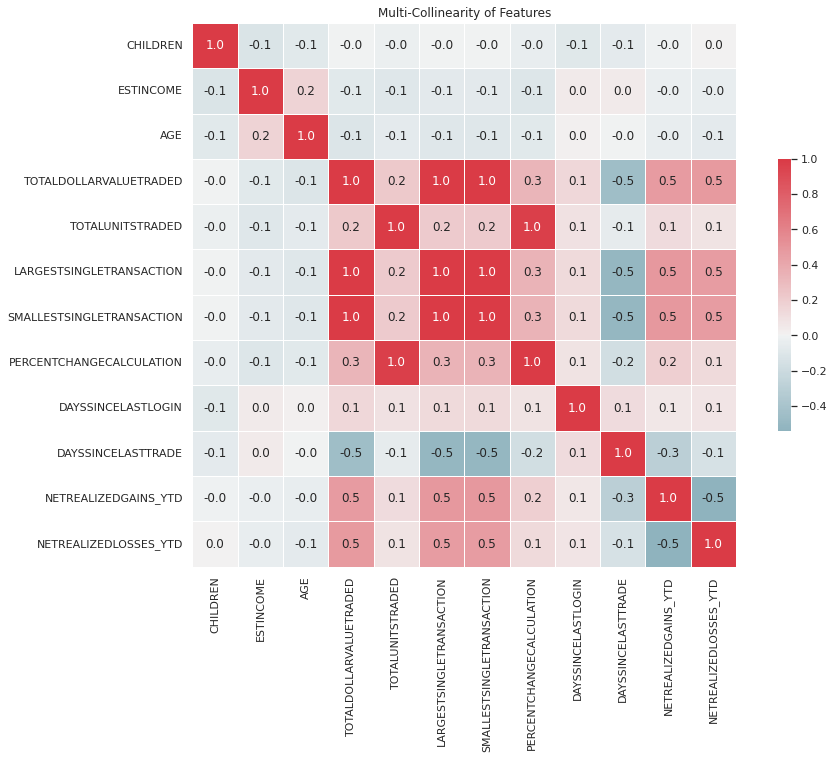

In [300]:
# Heatmap of the dataset
sns.set(style="white")
corr = data_num.corr()
mask = np.zeros_like(corr, dtype=bool)
f, ax = plt.subplots(figsize=(15,10))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,mask=mask,annot=True, cmap=cmap,vmax=1,center=0,fmt='.1f',square=True,linewidth=.5, cbar_kws={'shrink': .5})
ax.set_title('Multi-Collinearity of Features')

Multi-colinearity occurs when multiple features in a statistical model are highly correlated with each other. This undermines the model's validity as the two variables are not independent from each other and the model can't accurately determine the significance of each in predicting the target outcome. Below is the table which describes the correlation and it's level of strength. 
<table>
  <tr>
    <th>Value</th>
    <th>Strength</th>
  </tr>
  <tr>
    <td>r = ±1</td>
    <td>Perfectly Correlated</td>
  <tr>
  <tr>
    <td>±0.7 ≤ r < ±1</td>
    <td>Strongly Correlated</td>
  <tr>
  <tr>
    <td>±0.4 ≤ r < ±0.7</td>
    <td>Moderately Correlated</td>
  <tr>
  <tr>
    <td>±0.1 ≤ r < ±0.4	</td>
    <td>Weakly Correlated</td>
  <tr>
  <tr>
    <td>0 ≤ r < ±0.1</td>
    <td>Negligible Correlation</td>
  <tr>
</table>

As we can see on the heatmap above, there are features which are strongly correlated with other features such as, TOTALUNITSTRADED and PERCENTAGECHANGECALCULATION, TOTALDOLLARVALUETRADED and SMALLESTSINGLETRANSACTION, LARGESTSINGLETRANSACTION and SMALLESTSINGLETRANSACTION. We should drop these for the better modal prediction which we will do in data cleaning process. 

## Data Cleaning
Data cleaning involves the process of identifying and fixing any inaccuracies, inconsistencies, or missing values in our data set. This is an important step because these issues can negatively impact the accuracy and reliability of any downstream analysis or modeling we may perform.

In [301]:
# Removing the strongly correlated features with other features 
multicol_features = ['TOTALUNITSTRADED', 'PERCENTCHANGECALCULATION', 'TOTALDOLLARVALUETRADED', 'SMALLESTSINGLETRANSACTION']
# Dropping the multicolinear features
data_num = data_num.drop(multicol_features, axis = 1)

In [302]:
print(data_num.shape)

(2066, 8)


As we can see the shape of the dataset here, we now have only 7 important features out of 12 numerical features.

In [303]:
# Handling missing data
new_dataset = data_num.loc[:, data_num.isnull().any()].columns

data = []
percent_nan = []

for i in new_dataset:
    data.append(i)
    percent_nan.append(round(data_num[i].isnull().sum() * 100 / len(data_num), 2))

missing_df_train = pd.DataFrame(np.array(data),\
                                columns=["columns"])
missing_df_train['percent_nan'] = np.array(percent_nan)
print(missing_df_train)

Empty DataFrame
Columns: [columns, percent_nan]
Index: []


No missing values found in numerical features

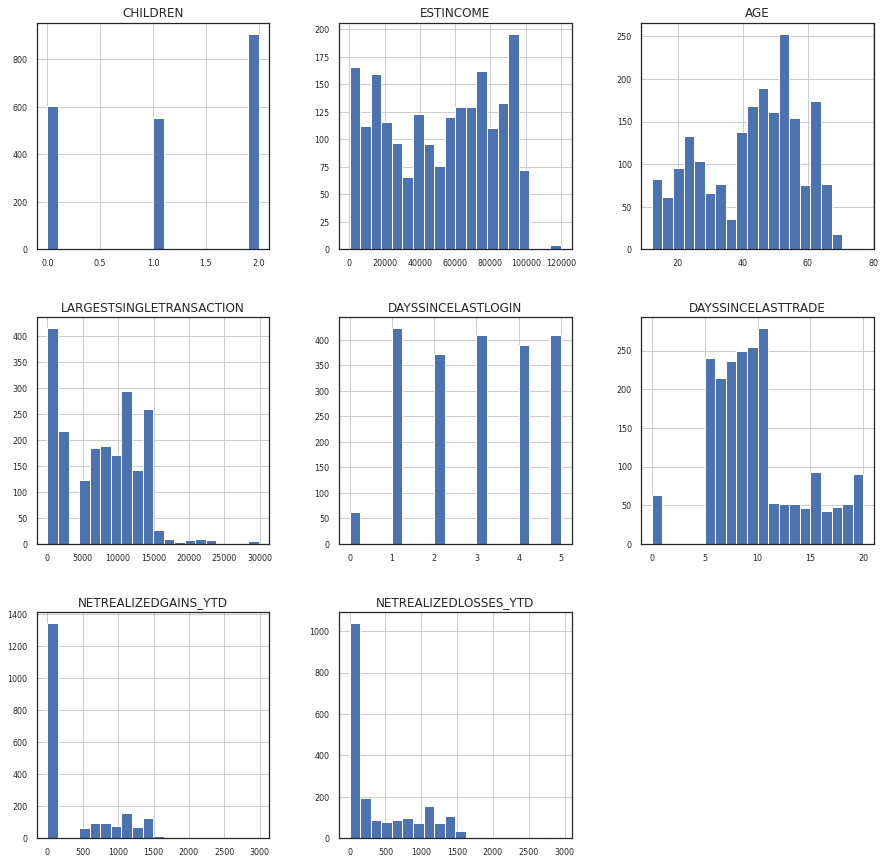

In [304]:
# Plotting the distribution of dataset (frequency vs value)
data_num.hist(figsize=(15, 15), bins=20,xlabelsize=8, ylabelsize=8)
plt.show()

# Categorical Feature Exploration
Categorical feature exploration refers to the process of analyzing and understanding the relationships between a categorical variable and other variables in a dataset. A categorical variable is a type of variable that can take on one of a limited, and usually fixed, number of possible values, such as "Male" or "Female" or "Red", "Green" and "Blue".

In [305]:
# Categorize the features depending on their datatype (int, float, object) 
obj = (data_cat.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

Categorical variables: 4


In [306]:
# Handling missing data on categorical features
data_cat_nan = data_cat.loc[:, data_cat.isnull().any()].columns
print(data_cat_nan)

Index([], dtype='object')


# Data Encoding
This is a process of converting categorical data into a numerical representation that can be used as input for the algorithms. This is necessary because many machine learning algorithms can only process numerical data. Common techniques for data encoding in machine learning include one-hot encoding, label encoding, and binary encoding. The choice of encoding technique depends on the nature of the data and the requirements of the machine learning algorithm being used. We will perform one hot encoding for this experiment because it is simple and effective where each category is represented as a binary vector of one "hot" (set to 1) and all other elements with "cold" (set to 0). 

In [307]:
# Apply label encoding
label = LabelEncoder()
data_cat.head()
data_cat_encoded = data_cat.copy(deep = True)
data_cat_encoded['CHURNRISK'] = label.fit_transform(dataset['CHURNRISK'])

churnrisk_mapping = dict(zip(label.classes_, label.transform(label.classes_)))
print(churnrisk_mapping)

data_cat_encoded['GENDER'] = label.fit_transform(dataset['GENDER'])
data_cat_encoded['STATUS'] = label.fit_transform(dataset['STATUS'])
data_cat_encoded['HOMEOWNER'] = label.fit_transform(dataset['HOMEOWNER'])
#data_hot = pd.get_dummies(data_cat)
data_cat_encoded.head()

{'High': 0, 'Low': 1, 'Medium': 2}


,CHURNRISK,GENDER,STATUS,HOMEOWNER
0,2,1,1,0
1,1,1,1,1
2,1,0,2,0
3,0,1,1,0
4,0,0,2,1


## Data Preparation
Apply standardization on the numerical features before merging the numerical and categorical data. 

In [308]:
# Standardizing data
scaler = StandardScaler()
data_num_scaled = pd.DataFrame(scaler.fit_transform(data_num),columns = data_num.columns)

In [309]:
# Merge the dataset
data_merged = pd.concat([data_num_scaled, data_cat_encoded], axis = 1)
print(f'Merged dataset shape: {data_merged.shape}')

data_merged.head()

Merged dataset shape: (2066, 12)


,CHILDREN,ESTINCOME,AGE,LARGESTSINGLETRANSACTION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD,CHURNRISK,GENDER,STATUS,HOMEOWNER
0,1.012959,-0.738588,0.281434,-1.168367,-0.602899,0.857719,-0.679273,-0.510607,2,1,1,0
1,1.012959,1.290924,-1.193460,1.084439,0.732138,0.151724,1.835463,-0.795935,1,1,1,1
2,-1.359800,0.705049,-0.053769,0.659009,0.732138,-1.024934,1.414322,-0.795935,1,0,2,0
3,-0.173420,0.431137,0.616638,-0.227619,0.064619,-0.789603,-0.679273,0.422898,0,1,1,0
4,-1.359800,1.357483,-0.187850,1.360216,0.732138,-0.083608,-0.679273,1.998506,0,0,2,1


In [310]:
# Split the dataset into train and test
X = data_merged[[x for x in data_merged.columns if x != 'CHURNRISK']]
y = data_merged['CHURNRISK']

# Get the shape of X and y
print("Dataset Shape:", X.shape, "Labels Shape:", y.shape)

# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=0.20, shuffle=True)

print("Train shape:", X_train.shape, "Test Shape:", X_test.shape)

Dataset Shape: (2066, 11) Labels Shape: (2066,)
Train shape: (1652, 11) Test Shape: (414, 11)


# Model Building
Let's build the model using Radial Basis Kernel Support Vector Machine (Kernel-SVM). The RBF kernel is highly versatile in terms of kernelization and is commonly used because it resembles the Gaussian distribution. It is used to determine the similarity or proximity between two points, X₁ and X₂. The gamma parameter determines the range of influence of a single training example, where low values indicate a wide range and high values indicate a narrow range. Essentially, gamma acts as the inverse of the radius of influence of the model's selected support vectors. When gamma is set to a high value, the support vector's area of influence is so small that no amount of regularization with can prevent overfitting. So I am keeping low gamma values for this project. 

In [311]:
rbk_svm = SVC(kernel='rbf', probability=True, C=1, gamma=0.1)
rbf_model = rbk_svm.fit(X_train, y_train)

In [312]:
# Predict class labels on training data
pred_labels_tr = rbf_model.predict(X_train)
# Predict class labels on a test data
y_pred_1 = rbf_model.predict(X_test)

In [313]:
cm = confusion_matrix(y_test,y_pred_1)

Churn Risk Mapping: {'High': 0, 'Low': 1, 'Medium': 2}


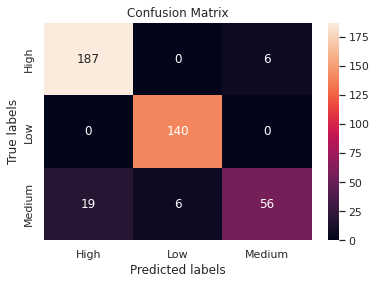

In [314]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

# Get the true labels
print("Churn Risk Mapping:", churnrisk_mapping)

ax.xaxis.set_ticklabels(['High', 'Low', 'Medium']); ax.yaxis.set_ticklabels(['High', 'Low', 'Medium']);

In [315]:
# Use score method to get accuracy of the rbf_model
print('----- Evaluation on Test Data for SVM model -----')
score_te = rbf_model.score(X_test, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the rbf_model
print(classification_report(y_test, y_pred_1))
print('--------------------------------------------------------')

----- Evaluation on Test Data for SVM model -----
Accuracy Score:  0.9251207729468599
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       193
           1       0.96      1.00      0.98       140
           2       0.90      0.69      0.78        81

    accuracy                           0.93       414
   macro avg       0.92      0.89      0.90       414
weighted avg       0.92      0.93      0.92       414

--------------------------------------------------------


#### ROC Curve

The target variable we have here in this dataset has three different values, High, Low and Medium. So we cannot implement the ROC Curve directly. Either we should use OvR (One vs Rest) or OvO (One vs One) strategy. 

In [316]:
# We need these following dependency functions to generate ROC Curve 
# These functions were referenced from the blog post mentioned below
# Ref: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
# Plots the Probability Distributions and the ROC Curves One vs Rest
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

Class: 0
Class: 1
Class: 2


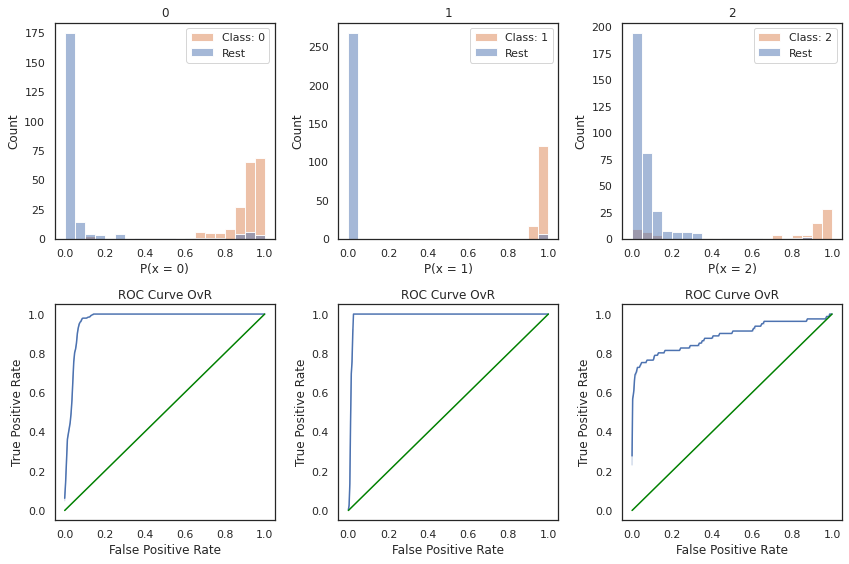

In [317]:
# ROC Curve for Task 1 (Radial Bias Kernel Support Vector Machines: Kernel-SVM)
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = rbf_model.classes_
roc_auc_ovr = {}
y_proba = rbf_model.predict_proba(X_test)

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    print('Class:', c)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

## Task 2

Now let's do Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA) and represent the features in the lower dimensional space (k <<<< 15). Then apply the SVM on both lower dimensional feature space and analysis the results. Before that, we need to know the suitable number of component k. 

In [318]:
# Let's again create a fresh numerical and categorial data for task 2
# Extracting the numerical features
data_num = dataset.select_dtypes(include='number')
# Extracting the categorical features
data_cat = dataset.select_dtypes('object')

# Perform label encoding
# Apply one-hot label encoding
label = LabelEncoder()
data_cat.head()
data_cat_encoded = data_cat.copy(deep = True)
data_cat_encoded['CHURNRISK'] = label.fit_transform(dataset['CHURNRISK'])

churnrisk_mapping = dict(zip(label.classes_, label.transform(label.classes_)))
print(churnrisk_mapping)

data_cat_encoded['GENDER'] = label.fit_transform(dataset['GENDER'])
data_cat_encoded['STATUS'] = label.fit_transform(dataset['STATUS'])
data_cat_encoded['HOMEOWNER'] = label.fit_transform(dataset['HOMEOWNER'])
#data_hot = pd.get_dummies(data_cat)
data_cat_encoded.head()

# Standardizing data
scaler = StandardScaler()
data_num_scaled = pd.DataFrame(scaler.fit_transform(data_num),columns = data_num.columns)

# Merge the dataset
data_merged = pd.concat([data_num_scaled, data_cat_encoded], axis = 1)
print(f'Merged dataset shape: {data_merged.shape}')

data_merged.head()

# Split the dataset into train and test
X = data_merged[[x for x in data_merged.columns if x != 'CHURNRISK']]
y = data_merged['CHURNRISK']

# Get the shape of X and y
print("Dataset Shape:", X.shape, "Labels Shape:", y.shape)

# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=0.20, shuffle=True)

{'High': 0, 'Low': 1, 'Medium': 2}
Merged dataset shape: (2066, 16)
Dataset Shape: (2066, 15) Labels Shape: (2066,)


#### Data Preprocessing
In order to use PCA effectively, it is crucial to determine the suitable number of components needed to portray the data. This can be accomplished by examining the cumulative explained variance ratio in relation to the number of components.

#### Principal Component Analysis (PCA)

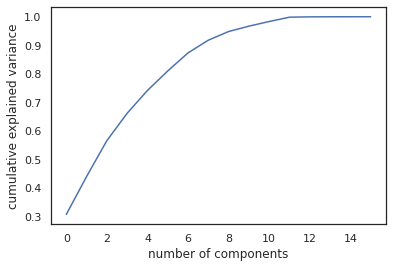

In [319]:
# Choosing the number of components
pca = PCA().fit(data_merged)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

As we can see on the graph above, the first 5 components contains about 85% of the variance and the first 8 components contains about 95% of the variance while we need altogether 10 components to describe 100% of the variance. Now, let's do the PCA using 8 components.

In [320]:
pca = PCA(n_components=5)
X_train_reduced = pca.fit(X_train).transform(X_train)
X_test_reduced = pca.fit(X_test).transform(X_test)
print("Original Shape:", X_train.shape)
print("Reduced Shape:", X_train_reduced.shape)

Original Shape: (1652, 15)
Reduced Shape: (1652, 5)


In [321]:
# Let's create a SVM model now. I am creating the Radial Basis Kernel Support Vector Model here so that I can compare with the results from task 1
pca_rbk_svm = SVC(kernel='rbf', probability=True, C=1, gamma=0.1)
pca_svm_model = pca_rbk_svm.fit(X_train_reduced, y_train)

In [322]:
# Predict class labels on training data
pred_labels_tr = pca_svm_model.predict(X_train_reduced)
# Predict class labels on a test data
y_pred_2 = pca_svm_model.predict(X_test_reduced)

In [323]:
cm = confusion_matrix(y_test,y_pred_2)

Churn Risk Mapping: {'High': 0, 'Low': 1, 'Medium': 2}


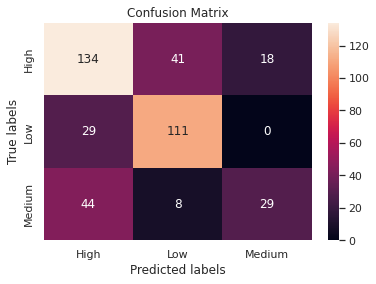

In [324]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

# Get the true labels
print("Churn Risk Mapping:", churnrisk_mapping)

ax.xaxis.set_ticklabels(['High', 'Low', 'Medium']); ax.yaxis.set_ticklabels(['High', 'Low', 'Medium']);

In [325]:
# Use score method to get accuracy of the pca_svm_model
print('----- Evaluation on Test Data for SVM model using PCA -----')
score_te = pca_svm_model.score(X_test_reduced, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the pca_svm_model
print(classification_report(y_test, y_pred_2))
print('--------------------------------------------------------')

----- Evaluation on Test Data for SVM model using PCA -----
Accuracy Score:  0.6618357487922706
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       193
           1       0.69      0.79      0.74       140
           2       0.62      0.36      0.45        81

    accuracy                           0.66       414
   macro avg       0.65      0.62      0.62       414
weighted avg       0.66      0.66      0.65       414

--------------------------------------------------------


#### Linear Discriminant Analysis

In [326]:
# Find out the optimal number of components for LDA 
# X is the feature matrix and y is the target variable
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Calculate the explained variance for each component
explained_variances = lda.explained_variance_ratio_

# Calculate the cumulative sum of explained variances
cumulative_variances = np.cumsum(explained_variances)

# Find the optimal number of components
optimal_num_components = np.argmax(cumulative_variances >= 0.95) + 1

print(f"Optimal number of components: {optimal_num_components}")

Optimal number of components: 2


In [327]:
# Now build the LDA model with 2 components.
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train)
# Transform the training and testing data to the LDA space
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)


In [328]:
# Let's create a SVM model now. I am creating the Radial Basis Kernel Support Vector Model here so that I can compare with the results from task 1
lda_rbk_svm = SVC(kernel='rbf', probability=True, C=1, gamma=0.1)
lda_svm_model = lda_rbk_svm.fit(X_train_lda, y_train)

In [329]:
# Predict class labels on training data
pred_labels_tr = lda_svm_model.predict(X_train_lda)
pred_prob_3 = lda_svm_model.predict_proba(X_train_lda)
# Predict class labels on a test data
y_pred_3 = lda_svm_model.predict(X_test_lda)

In [330]:
cm = confusion_matrix(y_test,y_pred_3)

Churn Risk Mapping: {'High': 0, 'Low': 1, 'Medium': 2}


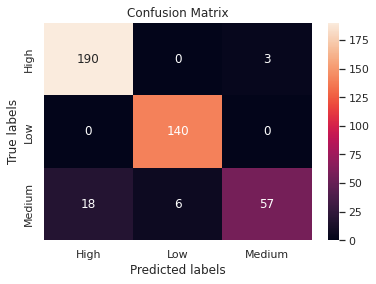

In [331]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

# Get the true labels
print("Churn Risk Mapping:", churnrisk_mapping)

ax.xaxis.set_ticklabels(['High', 'Low', 'Medium']); ax.yaxis.set_ticklabels(['High', 'Low', 'Medium']);

In [332]:
# Use score method to get accuracy of the lda_svm_model
print('----- Evaluation on Test Data for SVM model using LDA -----')
score_te = lda_svm_model.score(X_test_lda, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the lda_svm_model
print(classification_report(y_test, y_pred_3))
print('--------------------------------------------------------')

----- Evaluation on Test Data for SVM model using LDA -----
Accuracy Score:  0.9347826086956522
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       193
           1       0.96      1.00      0.98       140
           2       0.95      0.70      0.81        81

    accuracy                           0.93       414
   macro avg       0.94      0.90      0.91       414
weighted avg       0.94      0.93      0.93       414

--------------------------------------------------------


#### ROC Curve

The target variable we have here in this dataset has three different values, High, Low and Medium. So we cannot implement the ROC Curve directly. Either we should use OvR (One vs Rest) or OvO (One vs One) strategy. 

Class: 0
Class: 1
Class: 2


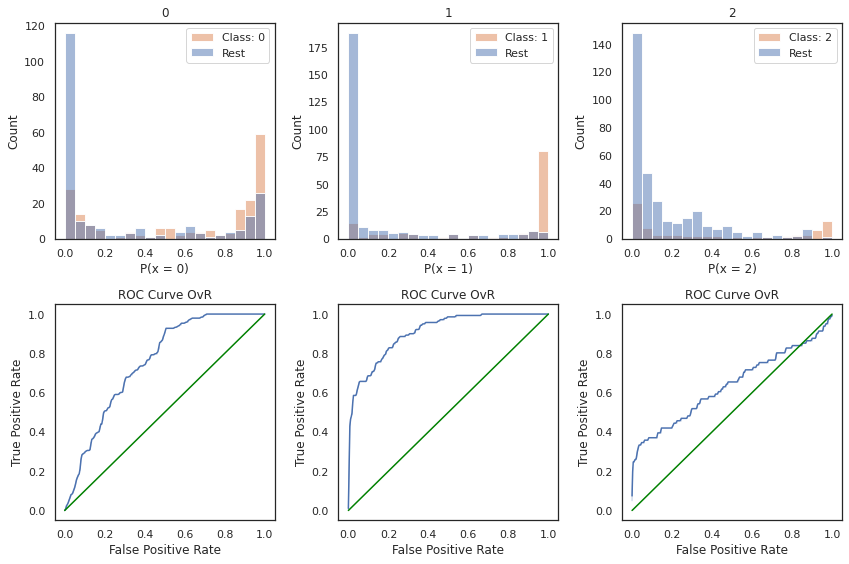

In [333]:
# ROC Curve for SVM using PCA
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = pca_svm_model.classes_
roc_auc_ovr = {}
y_proba = pca_svm_model.predict_proba(X_test_reduced)

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    print('Class:', c)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

Class: 0
Class: 1
Class: 2


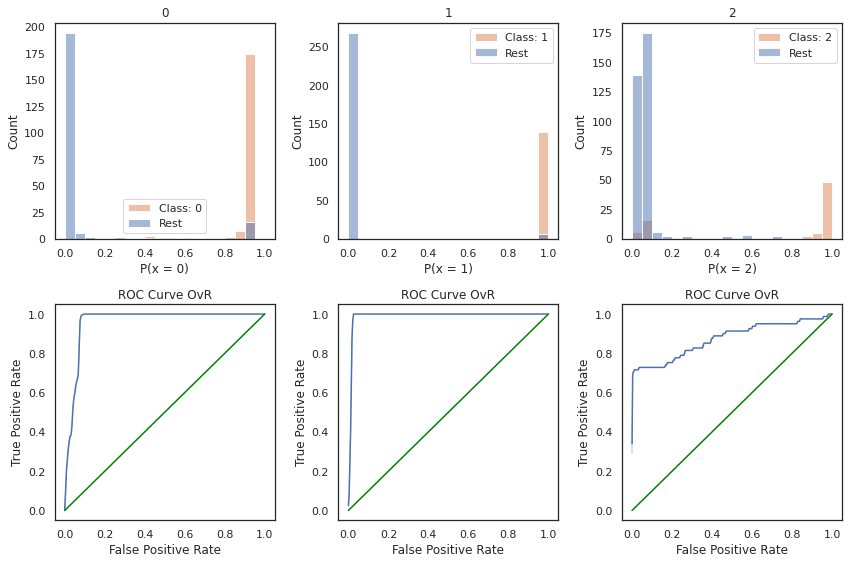

In [334]:
# ROC Curve for SVM using LDA
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = lda_svm_model.classes_
roc_auc_ovr = {}
y_proba = lda_svm_model.predict_proba(X_test_lda)

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    print('Class:', c)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

### Conclusion
Three different SVM models were created using different feature reduction techniques such as Exploratory Data Analysis (EDA) with numerical and categorical analysis, Principal Component Analysis (PCA), and Linear Discriminant Analysis (LDA) with an optimal component selection strategy. Among these models, the one that employed LDA performed the best on the test dataset, achieving an accuracy of 94.47\% and an f1 score of 0.93.